# Effect of XGBoost on Stock Market Prediction

In this notebook we will have a look into XGBoost for stock market prediction

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Gathering data
# TODO : Create function to get data from yfinance to be used in future projects
ticker =  "AMZN"
today = date.today()

amzn = yf.download(ticker, start = "2020-01-01", end = date.today() )

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Verifying there are no null or na values
print(f"NA Sum: \n{amzn.isna().sum()}\n")
print(f"Null Sum: \n{amzn.isnull().sum()}")

NA Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64

Null Sum: 
Price   Ticker
Close   AMZN      0
High    AMZN      0
Low     AMZN      0
Open    AMZN      0
Volume  AMZN      0
dtype: int64


In [4]:
# Adding features that could be relevant to the model

amzn['SMA_5'] = amzn['Close'].rolling(window = 5).mean()
amzn['EMA_5'] = amzn['Close'].ewm(span = 5, adjust = False).mean()
amzn['MACD'] = amzn['Close'].rolling(window = 12).mean() - amzn['Close'].rolling(window = 26).mean()
amzn['Return'] = amzn['Close'].pct_change()
amzn['Volatility_5'] = amzn['Close'].rolling(window = 5).std()
amzn['Target'] = amzn['Close'].shift(-1)
amzn['Lag_1'] = amzn['Close'].shift(1)
amzn['Lag_2'] = amzn['Close'].shift(2)

amzn.head(10)

Price,Close,High,Low,Open,Volume,SMA_5,EMA_5,MACD,Return,Volatility_5,Target,Lag_1,Lag_2
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,94.900497,94.900497,93.207497,93.750000,80580000,NaN,94.900497,NaN,NaN,NaN,93.748497,NaN,NaN
2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000,NaN,94.516497,NaN,-0.012139,NaN,95.143997,94.900497,NaN
2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000,NaN,94.725664,NaN,0.014886,NaN,95.343002,93.748497,94.900497
2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000,NaN,94.931443,NaN,0.002092,NaN,94.598503,95.143997,93.748497
2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000,94.746899,94.820463,NaN,-0.007809,0.623588,95.052498,95.343002,95.143997
2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000,94.777299,94.897808,NaN,0.004799,0.636519,94.157997,94.598503,95.343002
2020-01-10,94.157997,95.347000,94.000000,95.268501,57074000,94.859200,94.651204,NaN,-0.009411,0.477542,94.565002,95.052498,94.598503
2020-01-13,94.565002,94.900002,94.040001,94.565498,55616000,94.743401,94.622470,NaN,0.004323,0.461135,93.472000,94.157997,95.052498


In [5]:
amzn.dropna(inplace = True)
amzn.head()

Price,Close,High,Low,Open,Volume,SMA_5,EMA_5,MACD,Return,Volatility_5,Target,Lag_1,Lag_2
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,,,,,,,,
Date,,,,,,,,,,,,,
2020-02-07,103.963997,104.926498,101.904999,102.099503,101906000,102.232498,101.847784,1.697608,0.014169,1.349681,106.695503,102.511497,101.993500
2020-02-10,106.695503,106.779999,104.248001,104.250504,101124000,103.529599,103.463691,2.282830,0.026274,1.917167,107.540001,103.963997,102.511497
2020-02-11,107.540001,109.297501,106.800003,107.544998,114920000,104.540900,104.822461,2.957221,0.007915,2.478783,108.000000,106.695503,103.963997
2020-02-12,108.000000,109.012497,107.764503,108.160004,66686000,105.742200,105.881641,3.844676,0.004277,2.389455,107.493500,107.540001,106.695503
2020-02-13,107.493500,108.514000,107.099998,107.249496,60636000,106.738600,106.418927,4.613266,-0.004690,1.620457,106.743500,108.000000,107.540001


In [6]:
split_value = 0.8
split_index = int(split_value * len(amzn))
features = ['Close', 'SMA_5', 'EMA_5', 'MACD', 'Return', 'Volatility_5']


X_train = amzn[features].iloc[:split_index]
y_train = amzn['Target'].iloc[:split_index]

X_test = amzn[features].iloc[split_index:]
y_test = amzn['Target'].iloc[split_index:]


In [7]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()

model = XGBRegressor(random_state = 1000, n_estimators = 1000, max_depth = 5, learning_rate=0.3)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [8]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mse)

678.2862355087464


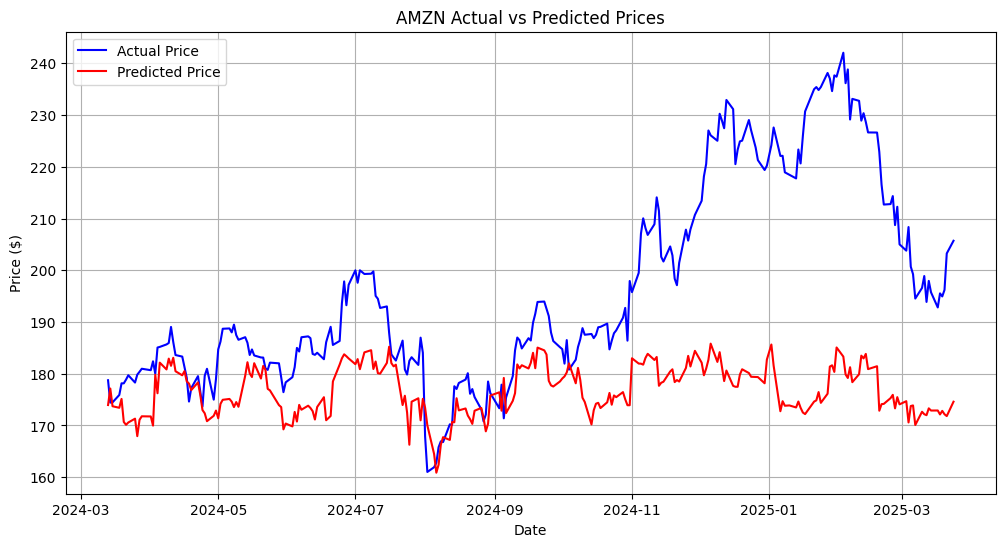

In [9]:
# Plotting the predictions

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label = "Actual Price", color = "blue")
plt.plot(y_test.index, y_pred, label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

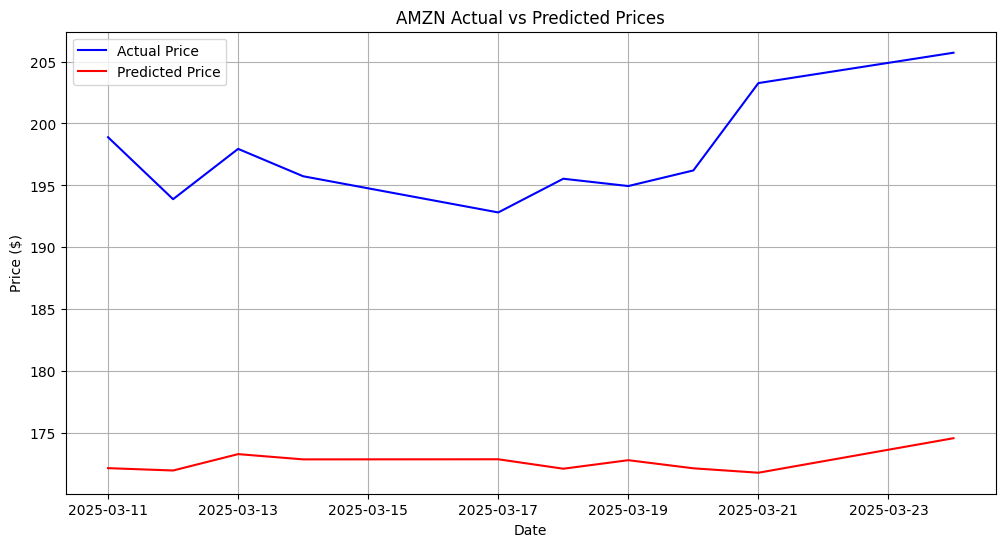

In [10]:
# Last 10 days
plt.figure(figsize=(12,6))
plt.plot(y_test.index[-10:], y_test[-10:], label = "Actual Price", color = "blue")
plt.plot(y_test.index[-10:], y_pred[-10:], label = "Predicted Price", color = "red")
plt.title(f"{ticker} Actual vs Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

The results for XGBoost are not as expected. However, parameter tuning can help us achieve a lower mse.

In [11]:
results_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_comparison.tail()

,Actual,Predicted
Date,,
2025-03-18,195.539993,172.137238
2025-03-19,194.949997,172.825195
2025-03-20,196.210007,172.170349
2025-03-21,203.259995,171.813980
2025-03-24,205.710007,174.598373
